# Cloud Computing Project # 3

### Using Sagemaker Notebooks in conjunction with PySpark to cluster and classify MNIST data.

### Created by Joe Littell

This project is to run two machine learning models on the MNIST Data Set. 

The first model is K Means Clustering. This algorithm clusters based off a number 'K' entered as a parameter. In this case we give the model K = 10, representing the numbers 0 through 9 inclusive. It then determines membership to the clusters based off of uclidean distance from the center of the cluster. The closer the features are in N-Space, the more likely they are to be members of that cluster.

The second model XGBoost, or Extreme Gradient boosting. XGBoost differs from K Means as it is a ensemble decision tree model. By ensemble, we simply mean it uses different boosting methods to come to the most accurate answer. 

### Initializing Spark

In [6]:
import os
import boto3

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github to learn how to connect to EMR from a notebook instance
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()
    
spark

### Loading in the data

In [7]:
import boto3

region = boto3.Session().region_name
spark._jsc.hadoopConfiguration().set('fs.s3a.endpoint', 's3.{}.amazonaws.com'.format(region))

trainingData = spark.read.format('libsvm')\
    .option('numFeatures', '784')\
    .load('s3a://sagemaker-sample-data-{}/spark/mnist/train/'.format(region))

testData = spark.read.format('libsvm')\
    .option('numFeatures', '784')\
    .load('s3a://sagemaker-sample-data-{}/spark/mnist/test/'.format(region))

trainingData.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  5.0|(784,[152,153,154...|
|  0.0|(784,[127,128,129...|
|  4.0|(784,[160,161,162...|
|  1.0|(784,[158,159,160...|
|  9.0|(784,[208,209,210...|
|  2.0|(784,[155,156,157...|
|  1.0|(784,[124,125,126...|
|  3.0|(784,[151,152,153...|
|  1.0|(784,[152,153,154...|
|  4.0|(784,[134,135,161...|
|  3.0|(784,[123,124,125...|
|  5.0|(784,[216,217,218...|
|  3.0|(784,[143,144,145...|
|  6.0|(784,[72,73,74,99...|
|  1.0|(784,[151,152,153...|
|  7.0|(784,[211,212,213...|
|  2.0|(784,[151,152,153...|
|  8.0|(784,[159,160,161...|
|  6.0|(784,[100,101,102...|
|  9.0|(784,[209,210,211...|
+-----+--------------------+
only showing top 20 rows



### K Means Clustering of MNIST Data

In [8]:
from sagemaker_pyspark import IAMRole
from sagemaker_pyspark.algorithms import KMeansSageMakerEstimator
from sagemaker_pyspark import RandomNamePolicyFactory

# Create K-Means Estimator
kmeans_estimator = KMeansSageMakerEstimator(
    sagemakerRole = IAMRole(role),
    trainingInstanceType = 'ml.m4.xlarge', # Instance type to train K-means on SageMaker
    trainingInstanceCount = 1,
    endpointInstanceType = 'ml.t2.large', # Instance type to serve model (endpoint) for inference
    endpointInitialInstanceCount = 1,
    namePolicyFactory = RandomNamePolicyFactory("sparksm-1a-")) # All the resources created are prefixed with sparksm-1

# Set parameters for K-Means
kmeans_estimator.setFeatureDim(784)
kmeans_estimator.setK(10)

# Train The Model
initialModel = kmeans_estimator.fit(trainingData)

### Results of KMeans

In [9]:
# Show in tabular form the 
transformed_data = initialModel.transform(testData)
transformed_data.show()

+-----+--------------------+-------------------+---------------+
|label|            features|distance_to_cluster|closest_cluster|
+-----+--------------------+-------------------+---------------+
|  7.0|(784,[202,203,204...| 1380.1258544921875|            7.0|
|  2.0|(784,[94,95,96,97...|   1936.96923828125|            9.0|
|  1.0|(784,[128,129,130...| 1021.3196411132812|            3.0|
|  0.0|(784,[124,125,126...|   1691.60791015625|            4.0|
|  4.0|(784,[150,151,159...| 1554.9881591796875|            2.0|
|  1.0|(784,[156,157,158...|  915.0352172851562|            3.0|
|  4.0|(784,[149,150,151...| 1643.6688232421875|            2.0|
|  9.0|(784,[179,180,181...|        1657.671875|            2.0|
|  5.0|(784,[129,130,131...|    2084.2119140625|            2.0|
|  9.0|(784,[209,210,211...|   1402.69189453125|            7.0|
|  0.0|(784,[123,124,125...|   1498.63623046875|            4.0|
|  6.0|(784,[94,95,96,97...|  1787.052978515625|            9.0|
|  9.0|(784,[208,209,210.




Cluster A:


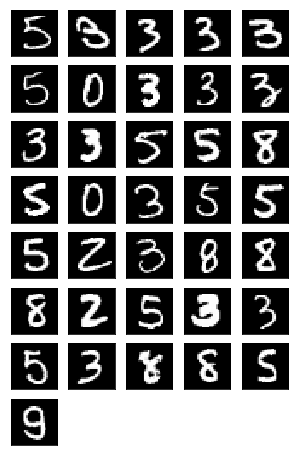




Cluster B:


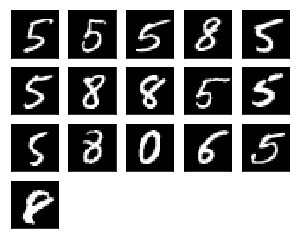




Cluster C:


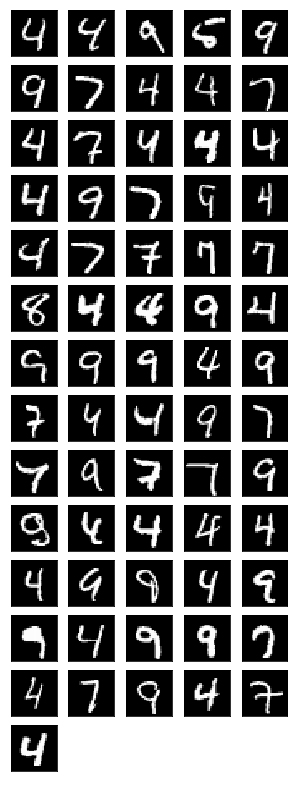




Cluster D:


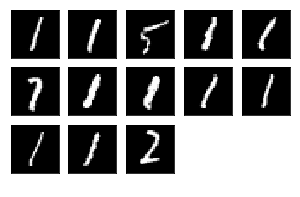




Cluster E:


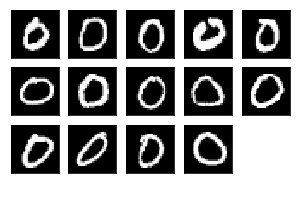




Cluster F:


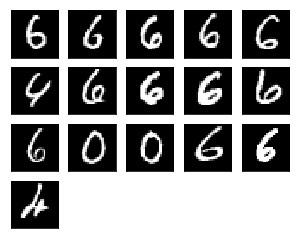




Cluster G:


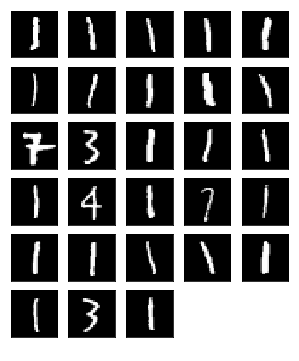




Cluster H:


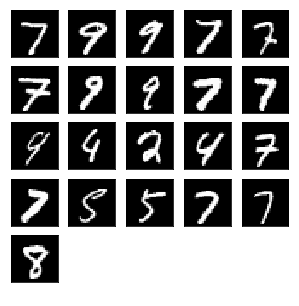




Cluster I:


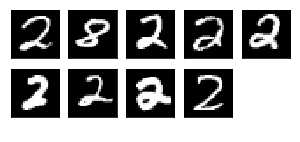




Cluster J:


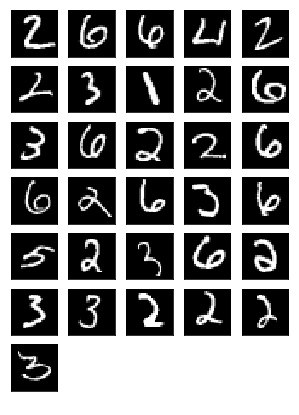

In [12]:
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import numpy as np
import string

# Helper function to display a digit
def showDigit(img, caption='', xlabel='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axes.get_xaxis().set_ticks([])
    subplot.axes.get_yaxis().set_ticks([])
    plt.title(caption)
    plt.xlabel(xlabel)
    subplot.imshow(imgr, cmap='gray')
    
def displayClusters(data):
    images = np.array(data.select("features").cache().take(250))
    clusters = data.select("closest_cluster").cache().take(250)

    for cluster in range(10):
        print('\n\n\nCluster {}:'.format(string.ascii_uppercase[cluster]))
        digits = [ img for l, img in zip(clusters, images) if int(l.closest_cluster) == cluster ]
        height=((len(digits)-1)//5)+1
        width=5
        plt.rcParams["figure.figsize"] = (width,height)
        _, subplots = plt.subplots(height, width)
        subplots=np.ndarray.flatten(subplots)
        for subplot, image in zip(subplots, digits):
            showDigit(image, subplot=subplot)
        for subplot in subplots[len(digits):]:
            subplot.axis('off')

        plt.show()
        
displayClusters(transformed_data)

### XGBoost Model of MNIST Data

In [14]:
from sagemaker_pyspark.algorithms import XGBoostSageMakerEstimator

xgboost_estimator = XGBoostSageMakerEstimator(
    trainingInstanceType="ml.m4.xlarge", # Instance type to train xgboost on SageMaker
    trainingInstanceCount=1,
    endpointInstanceType="ml.m4.xlarge", # Instance type to serve model (endpoint) for inference
    endpointInitialInstanceCount=1,
    sagemakerRole=IAMRole(role))

xgboost_estimator.setObjective('multi:softmax')
xgboost_estimator.setNumRound(25)
xgboost_estimator.setNumClasses(10)

xgboost_model = xgboost_estimator.fit(training_data)

### Results of XGBoost

In [15]:
transformed_data = xgboost_model.transform(test_data)
transformed_data.show()

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|  5.0|(784,[152,153,154...|       5.0|
|  0.0|(784,[127,128,129...|       0.0|
|  4.0|(784,[160,161,162...|       4.0|
|  1.0|(784,[158,159,160...|       1.0|
|  9.0|(784,[208,209,210...|       9.0|
|  2.0|(784,[155,156,157...|       2.0|
|  1.0|(784,[124,125,126...|       1.0|
|  3.0|(784,[151,152,153...|       3.0|
|  1.0|(784,[152,153,154...|       1.0|
|  4.0|(784,[134,135,161...|       4.0|
|  3.0|(784,[123,124,125...|       3.0|
|  5.0|(784,[216,217,218...|       5.0|
|  3.0|(784,[143,144,145...|       3.0|
|  6.0|(784,[72,73,74,99...|       6.0|
|  1.0|(784,[151,152,153...|       1.0|
|  7.0|(784,[211,212,213...|       7.0|
|  2.0|(784,[151,152,153...|       2.0|
|  8.0|(784,[159,160,161...|       8.0|
|  6.0|(784,[100,101,102...|       6.0|
|  9.0|(784,[209,210,211...|       9.0|
+-----+--------------------+----------+
only showing top 20 rows






Prediction A:


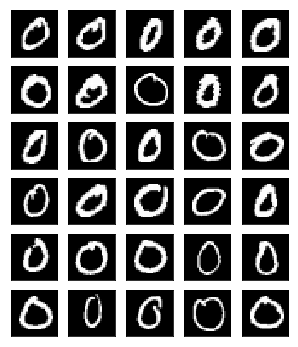




Prediction B:


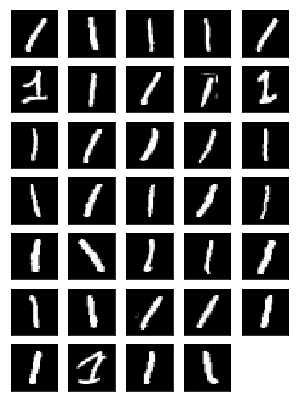




Prediction C:


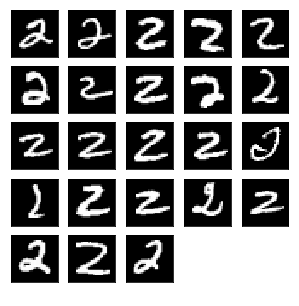




Prediction D:


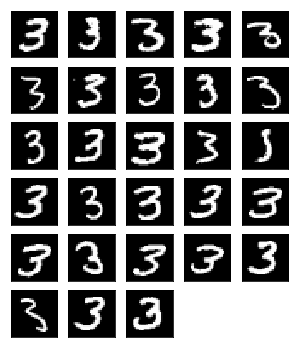




Prediction E:


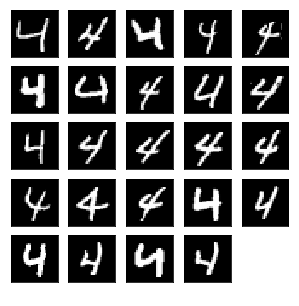




Prediction F:


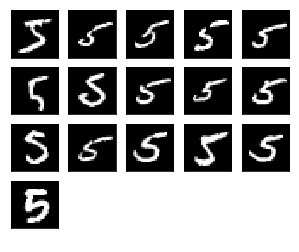




Prediction G:


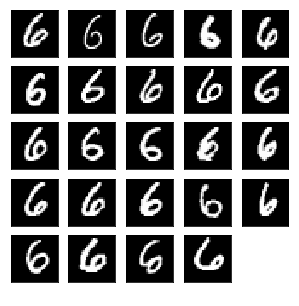




Prediction H:


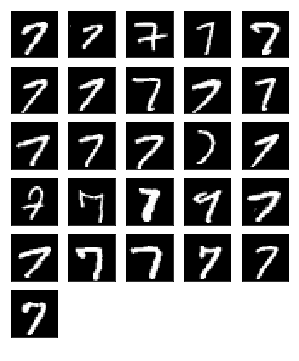




Prediction I:


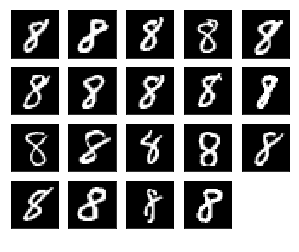




Prediction J:


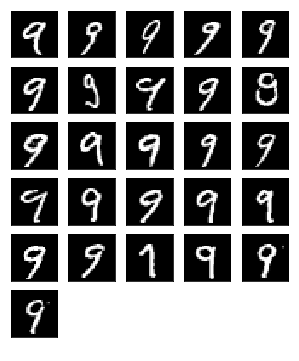

In [18]:
def showDigit(img, caption='', xlabel='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axes.get_xaxis().set_ticks([])
    subplot.axes.get_yaxis().set_ticks([])
    plt.title(caption)
    plt.xlabel(xlabel)
    subplot.imshow(imgr, cmap='gray')
    
def displayPredictions(data):
    images = np.array(data.select("features").cache().take(250))
    preds = data.select("prediction").cache().take(250)

    for pred in range(10):
        print('\n\n\nPrediction {}:'.format(string.ascii_uppercase[pred]))
        digits = [ img for l, img in zip(preds, images) if int(l.prediction) == pred ]
        height=((len(digits)-1)//5)+1
        width=5
        plt.rcParams["figure.figsize"] = (width,height)
        _, subplots = plt.subplots(height, width)
        subplots=np.ndarray.flatten(subplots)
        for subplot, image in zip(subplots, digits):
            showDigit(image, subplot=subplot)
        for subplot in subplots[len(digits):]:
            subplot.axis('off')

        plt.show()
        
displayPredictions(transformed_data)

### Conclusion

As we can see through the AUC for the ROC and the visualizations themselves, XGBoost performed substantially better in both speed and accuracy. 